In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
import re
import string
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('punk_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)


def load_data(file_path=None):
    if file_path:
        try:
            df = pd.read_csv(file_path)
            print(f"Data loaded successfully from {file_path}")
        except Exception as e:
            print(f"Error loading data: {e}")
            print("Using sample data instead.")
    else:
        print("No file path provided. Using sample data.")
    
    return df

def explore_data(df):
    """
    Explore the dataset structure and characteristics
    """
    print("Dataset Overview:")
    print(f"Shape: {df.shape}")
    print("\nColumns:")
    print(df.columns.tolist())
    print("\nData Types:")
    print(df.dtypes)
    print("\nSample Data:")
    print(df.head())
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    # Distribution of target classes
    print("\nTarget Class Distribution:")
    target_counts = df['target'].value_counts()
    print(target_counts)
    
    # Visualize the distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='target', data=df)
    plt.title('Distribution of Disaster vs Non-Disaster Tweets')
    plt.xlabel('Target Class (1: Disaster, 0: Non-Disaster)')
    plt.ylabel('Count')
    plt.show()
    
    # Check text length distribution
    df['text_length'] = df['text'].apply(len)
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='text_length', hue='target', bins=50, kde=True)
    plt.title('Distribution of Tweet Lengths by Target Class')
    plt.xlabel('Tweet Length (characters)')
    plt.ylabel('Frequency')
    plt.show()
    
    return df

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags symbol (keep the word)
    text = re.sub(r'#', '', text)
    
    # Remove punctuation
    text = re.sub(f'[{string.punctuation}]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def tokenize_text(text):
    """
    Tokenize the text into individual words
    """
    tokens = word_tokenize(text)
    return tokens

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

def stem_tokens(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

def preprocess_text(text):
    # Clean text
    cleaned_text = clean_text(text)
    
    # Tokenize
    tokens = tokenize_text(cleaned_text)
    
    # Remove stopwords
    tokens_without_stopwords = remove_stopwords(tokens)
    
    # Lemmatize
    lemmatized_tokens = lemmatize_tokens(tokens_without_stopwords)
    
    # Join tokens back into text
    processed_text = ' '.join(lemmatized_tokens)
    
    return processed_text

def prepare_data(df):
    # Apply preprocessing to the text
    print("Preprocessing text data...")
    df['processed_text'] = df['text'].apply(preprocess_text)
    
    # Display sample of processed text
    print("\nSample of processed text:")
    for i, (original, processed) in enumerate(zip(df['text'][:3], df['processed_text'][:3])):
        print(f"Original: {original}")
        print(f"Processed: {processed}")
        print()
    
    # Encode target variable if not already numeric
    if df['target'].dtype == 'object':
        label_encoder = LabelEncoder()
        df['target'] = label_encoder.fit_transform(df['target'])
    
    # Split data into features and target
    X = df['processed_text']
    y = df['target']
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Testing set size: {X_test.shape[0]}")
    
    return X_train, X_test, y_train, y_test

sample_tweet = "Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"
processed_tweet = preprocess_text(sample_tweet)

print("Original tweet:")
print(sample_tweet)
print("\nProcessed tweet:")
print(processed_tweet)

Original tweet:
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

Processed tweet:
deed reason earthquake may allah forgive u


[nltk_data] Error loading punk_tab: Package 'punk_tab' not found in
[nltk_data]     index


In [13]:
def extract_features(X_train, X_test, feature_type='tfidf'):
    """
    Extract features from text data using different methods
    """
    if feature_type == 'count':
        # Create bag of words features using CountVectorizer
        vectorizer = CountVectorizer(max_features=5000)
        X_train_features = vectorizer.fit_transform(X_train)
        X_test_features = vectorizer.transform(X_test)
    
    elif feature_type == 'tfidf':
        # Create TF-IDF features
        vectorizer = TfidfVectorizer(max_features=5000)
        X_train_features = vectorizer.fit_transform(X_train)
        X_test_features = vectorizer.transform(X_test)
    
    else:
        raise ValueError("Invalid feature type. Choose 'count' or 'tfidf'.")
    
    print(f"Feature type: {feature_type}")
    print(f"Training features shape: {X_train_features.shape}")
    print(f"Testing features shape: {X_test_features.shape}")
    
    # Show some feature names
    feature_names = vectorizer.get_feature_names_out()
    print(f"\nSample feature names: {feature_names[:10]}")
    
    return X_train_features, X_test_features, vectorizer

# Cell 9: Model Training
def train_model(X_train, y_train, model_type='logistic'):
    """
    Train various machine learning models
    """
    if model_type == 'logistic':
        model = LogisticRegression(max_iter=1000, random_state=42)
    elif model_type == 'random_forest':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_type == 'naive_bayes':
        model = MultinomialNB()
    elif model_type == 'svm':
        model = LinearSVC(random_state=42)
    else:
        raise ValueError("Invalid model type. Choose 'logistic', 'random_forest', 'naive_bayes', or 'svm'.")
    
    # Train the model
    print(f"Training {model_type} model...")
    model.fit(X_train, y_train)
    
    return model

# Cell 10: Build and Evaluate Multiple Models
def build_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Build and evaluate multiple models
    """
    # Define feature extraction methods
    feature_types = ['tfidf', 'count']
    
    # Define model types
    model_types = ['logistic', 'naive_bayes', 'random_forest', 'svm']
    
    # Store results
    results = []
    
    # Best model details
    best_model = None
    best_vectorizer = None
    best_f1 = 0
    
    for feature_type in feature_types:
        # Extract features
        X_train_features, X_test_features, vectorizer = extract_features(X_train, X_test, feature_type)
        
        for model_type in model_types:
            # Train model
            model = train_model(X_train_features, y_train, model_type)
            
            # Make predictions
            y_pred = model.predict(X_test_features)
            
            # Evaluate model
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            # Store results
            result = {
                'feature_type': feature_type,
                'model_type': model_type,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            }
            results.append(result)
            
            # Check if this is the best model so far
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_vectorizer = vectorizer
            
            print(f"Model: {model_type}, Features: {feature_type}")
            print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
            print("-" * 50)
    
    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    
    # Visualize results
    plt.figure(figsize=(12, 8))
    sns.barplot(x='model_type', y='f1_score', hue='feature_type', data=results_df)
    plt.title('F1 Score Comparison Across Models and Feature Types')
    plt.xlabel('Model Type')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)
    plt.show()
    
    return results_df, best_model, best_vectorizer

In [14]:
def evaluate_model(model, X_test, y_test, vectorizer=None):
    """
    Evaluate the model on test data
    """
    # Make predictions
    if vectorizer:
        X_test_features = vectorizer.transform(X_test)
        y_pred = model.predict(X_test_features)
    else:
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # ROC curve and AUC score
    try:
        # Get probability predictions
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test_features)[:, 1]
        else:
            # For models without predict_proba, use decision function if available
            if hasattr(model, 'decision_function'):
                y_prob = model.decision_function(X_test_features)
            else:
                y_prob = y_pred
        
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
        
        # Precision-Recall curve
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(recall_curve, precision_curve, color='blue', lw=2)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.show()
    except Exception as e:
        print(f"Could not generate ROC or PR curves: {e}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_pred': y_pred
    }

def analyze_errors(X_test, y_test, y_pred):
    """
    Analyze prediction errors to understand model weaknesses
    """
    # Create DataFrame with test data and predictions
    error_df = pd.DataFrame({
        'text': X_test,
        'true_label': y_test,
        'predicted_label': y_pred
    })
    
    # Identify false positives and false negatives
    false_positives = error_df[(error_df['true_label'] == 0) & (error_df['predicted_label'] == 1)]
    false_negatives = error_df[(error_df['true_label'] == 1) & (error_df['predicted_label'] == 0)]
    
    print(f"Number of false positives: {len(false_positives)}")
    print(f"Number of false negatives: {len(false_negatives)}")
    
    # Print examples of errors
    if not false_positives.empty:
        print("\nFalse Positive Examples (Non-disaster tweets classified as disaster):")
        for i, (idx, row) in enumerate(false_positives.iterrows()):
            print(f"{i+1}. {row['text']}")
            if i >= 2:  # Limit to 3 examples
                break
    
    if not false_negatives.empty:
        print("\nFalse Negative Examples (Disaster tweets classified as non-disaster):")
        for i, (idx, row) in enumerate(false_negatives.iterrows()):
            print(f"{i+1}. {row['text']}")
            if i >= 2:  # Limit to 3 examples
                break
    
    return false_positives, false_negatives

# Cell 12: Model Saving Function
import pickle

def save_model(model, vectorizer, model_filename='disaster_tweet_model.pkl', vectorizer_filename='vectorizer.pkl'):
    """
    Save the trained model and vectorizer to disk
    """
    # Save model
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    
    # Save vectorizer
    with open(vectorizer_filename, 'wb') as file:
        pickle.dump(vectorizer, file)
    
    print(f"Model saved as {model_filename}")
    print(f"Vectorizer saved as {vectorizer_filename}")

# Cell 13: Model Testing Function
def test_model_prediction(model, vectorizer, tweet_text):
    """
    Test the model on a new tweet
    """
    # Preprocess the tweet
    processed_text = preprocess_text(tweet_text)
    
    # Vectorize the text
    vectorized_text = vectorizer.transform([processed_text])
    
    # Make prediction
    prediction = model.predict(vectorized_text)[0]
    
    # Get prediction probability if available
    probability = None
    if hasattr(model, 'predict_proba'):
        probability = model.predict_proba(vectorized_text)[0][1]
        confidence_str = f"with {probability:.2%} confidence"
    else:
        confidence_str = ""
    
    # Print result
    result = "Disaster" if prediction == 1 else "Non-disaster"
    print(f"Original tweet: {tweet_text}")
    print(f"Processed tweet: {processed_text}")
    print(f"Prediction: {result} {confidence_str}")
    
    return prediction, probability

PART 1: DATA EXPLORATION AND PREPARATION
Data loaded successfully from C:/Users/user/Downloads/project 6/twitter_disaster (1).csv
Dataset Overview:
Shape: (7613, 5)

Columns:
['id', 'keyword', 'location', 'text', 'target']

Data Types:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Sample Data:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Missing Values:
id             0
keyword       61
location    2533
text           0
target         0
dtyp

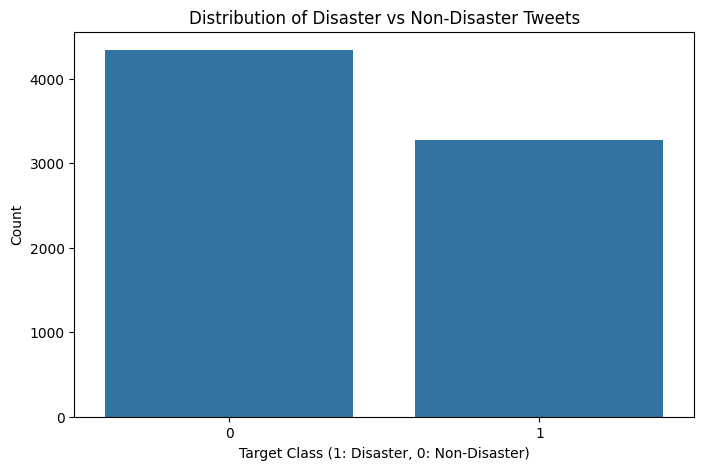

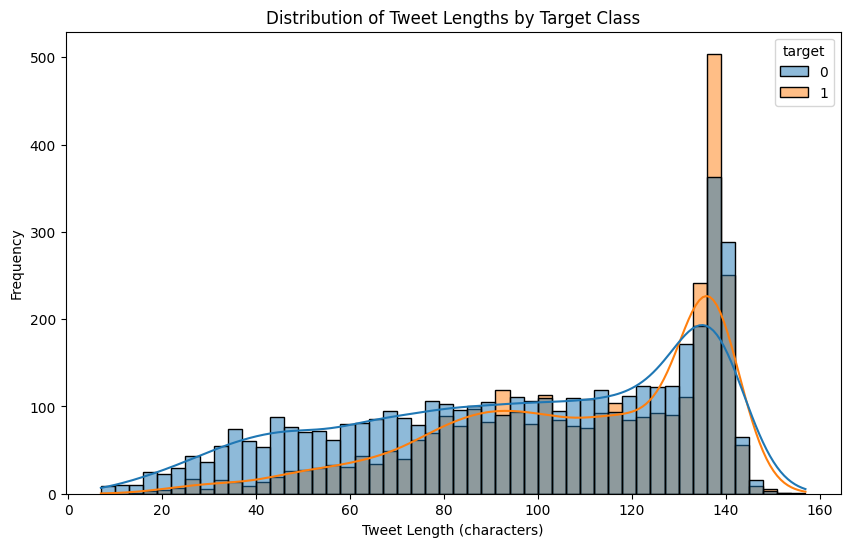

Preprocessing text data...

Sample of processed text:
Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Processed: deed reason earthquake may allah forgive u

Original: Forest fire near La Ronge Sask. Canada
Processed: forest fire near la ronge sask canada

Original: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Processed: resident asked shelter place notified officer evacuation shelter place order expected

Training set size: 6090
Testing set size: 1523

PART 2: FEATURE ENGINEERING AND MODEL SELECTION
Feature type: tfidf
Training features shape: (6090, 5000)
Testing features shape: (1523, 5000)

Sample feature names: ['001116' '010401' '02' '05' '06' '06jst' '09' '0day' '10' '100']
Training logistic model...
Model: logistic, Features: tfidf
Accuracy: 0.8234, Precision: 0.8468, Recall: 0.7187, F1-Score: 0.7775
--------------------------------------------------
Training 

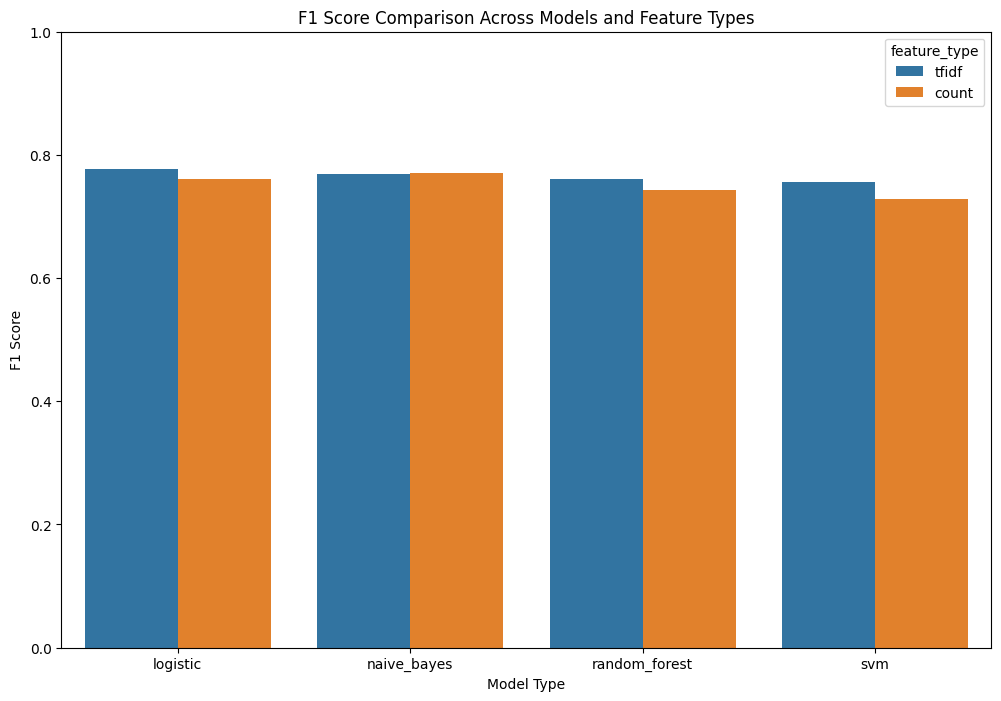


Best Model Configuration:
Model: logistic
Feature Type: tfidf
F1-Score: 0.7775

PART 3: MODEL EVALUATION AND VALIDATION
Model Evaluation Metrics:
Accuracy: 0.8234
Precision: 0.8468
Recall: 0.7187
F1-Score: 0.7775

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       869
           1       0.85      0.72      0.78       654

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.82      0.82      1523



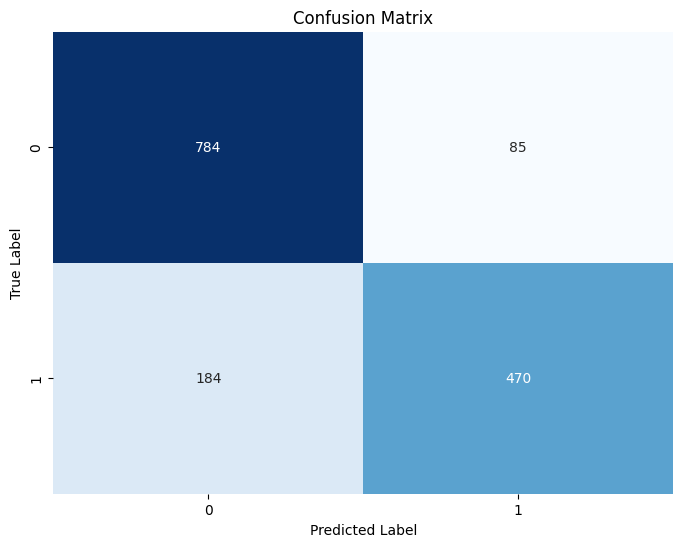

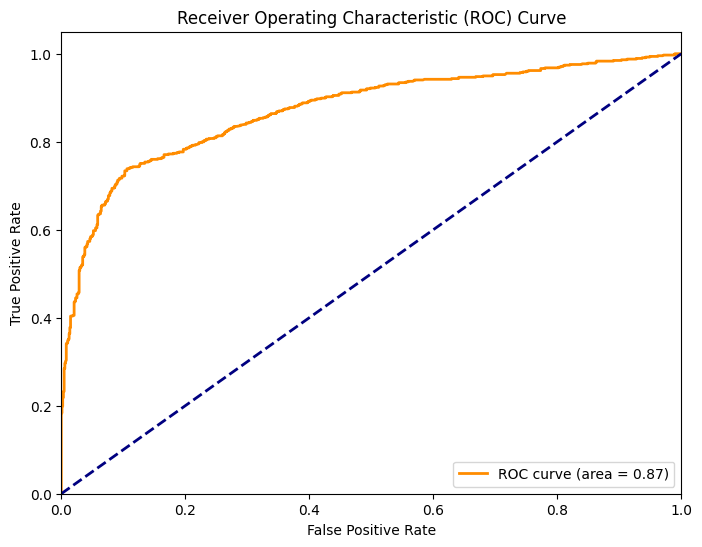

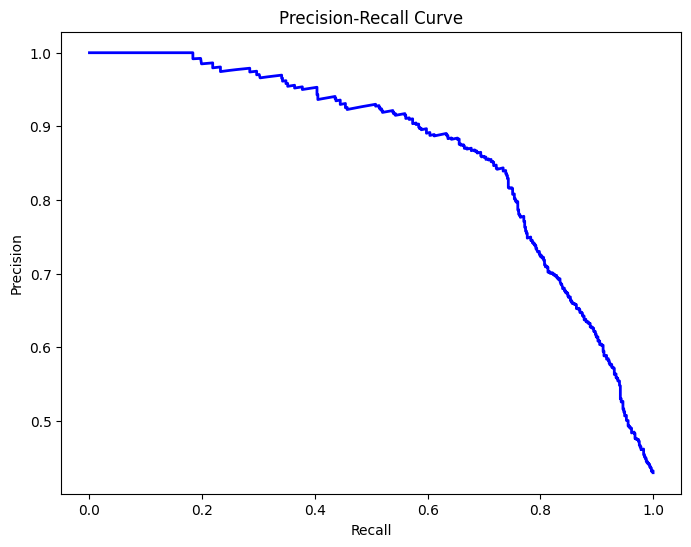

Number of false positives: 85
Number of false negatives: 184

False Positive Examples (Non-disaster tweets classified as disaster):
1. step one get mass murderer portrait yuan
2. firefighter acted like cop theyd drive around shooting flamethrower burning building
3. slicker oil spill

False Negative Examples (Disaster tweets classified as non-disaster):
1. hollywood movie trapped miner released chile 33 hollywood movie trapped miner starring
2. cant drown demon know swim
3. need plant pacific cyclone season would help

PART 4: MODEL SAVING AND TESTING
Model saved as disaster_tweet_model.pkl
Vectorizer saved as vectorizer.pkl

Testing model on sample tweets:
Original tweet: Just witnessed a terrible car accident on the highway. Emergency services on scene.
Processed tweet: witnessed terrible car accident highway emergency service scene
Prediction: Disaster with 75.49% confidence
----------------------------------------
Original tweet: I'm absolutely dying of laughter after watching that

In [16]:
def run_disaster_tweet_classification():
    """
    Run the complete workflow for the disaster tweet classification project
    """
    print("="*50)
    print("PART 1: DATA EXPLORATION AND PREPARATION")
    print("="*50)
    
    # Load data
    # In practice, you would use: 
    df = load_data('C:/Users/user/Downloads/project 6/twitter_disaster (1).csv')
    
    # Explore data
    df = explore_data(df)
    
    # Prepare data
    X_train, X_test, y_train, y_test = prepare_data(df)
    
    print("\n" + "="*50)
    print("PART 2: FEATURE ENGINEERING AND MODEL SELECTION")
    print("="*50)
    
    # Build and evaluate models
    results_df, best_model, best_vectorizer = build_and_evaluate_models(X_train, X_test, y_train, y_test)
    
    # Find the best model configuration
    best_result = results_df.loc[results_df['f1_score'].idxmax()]
    print("\nBest Model Configuration:")
    print(f"Model: {best_result['model_type']}")
    print(f"Feature Type: {best_result['feature_type']}")
    print(f"F1-Score: {best_result['f1_score']:.4f}")
    
    print("\n" + "="*50)
    print("PART 3: MODEL EVALUATION AND VALIDATION")
    print("="*50)
    
    # Evaluate the best model more thoroughly
    X_test_features = best_vectorizer.transform(X_test)
    y_pred = best_model.predict(X_test_features)
    eval_results = evaluate_model(best_model, X_test, y_test, best_vectorizer)
    
    # Analyze errors
    analyze_errors(X_test, y_test, y_pred)
    
    print("\n" + "="*50)
    print("PART 4: MODEL SAVING AND TESTING")
    print("="*50)
    
    # Save the model
    save_model(best_model, best_vectorizer)
    
    # Test the model on some sample tweets
    sample_tweets = [
        "Just witnessed a terrible car accident on the highway. Emergency services on scene.",
        "I'm absolutely dying of laughter after watching that comedy show!",
        "BREAKING: Massive earthquake hits downtown. Buildings collapsed, casualties reported.",
        "This new restaurant is on fire with their amazing food and service!",
        "Flood warnings issued for the entire county. Residents should seek higher ground immediately."
    ]
    
    print("\nTesting model on sample tweets:")
    for tweet in sample_tweets:
        test_model_prediction(best_model, best_vectorizer, tweet)
        print("-" * 40)
    
    return best_model, best_vectorizer, results_df

best_model, best_vectorizer, results_df = run_disaster_tweet_classification()


In [18]:
%tb

SystemExit: 1